# Wstęp
Zadanie 6 stanowi wprowadzenie w tematykę *data augmentation*. Ze względu na złożonośc modeli głębokich, zwykle wymagają one bardzo dużych zbiorów danych do dobrego wyuczenia. Jednym ze sposobów na skalowanie ilości dostępnych danych są metody tzw. augmentacji - przekształcenia na danych które mamy, aby utworzyć nowe przykłady o znanych etykietach. Pod koniec zadania wprowadzona jest również koncepcja *skip connections*, będących istotnym elementem współczesnych architektur konwolucyjnych i nie tylko.

#Cel ćwiczenia

Celem ćwiczenia jest zapoznanie się z

*    koncepcją augmentacji danych
*    implementacją metod augmentacji danych obrazowych w torch.transforms
*    koncepcją augmentacji niezależnej od dziedziny
*    modelami sieci głębokich ze skip connections

#Augmentacja danych obrazowych

W pierwszej kolejności zapoznajmy się z funkcjonalnością augmentacji danych obrazowych. W pytorch funkcjonalność ta realizowana jest przez transformacje wykonywane na obrazach przez `torchvision.transforms`.

Transformacje które typowo wykorzystuje się w augmentacji to standardowe przekształcenia afiniczne obrazu - rotacje, dobicia, skalowanie. Oczywiście, pownniśmy dobierać transformacje z takich, po których rzeczywiście oczekujemy inwariancji - przekształcony obraz będziemy podawać do sieci z tą samą etykietą. Przykładowo, na zbiorze odręcznie pisanych cyfr MNIST ograniczymy zakres obrotów czy wykorzystanie odbicia w osi poziomej, jako że niechcemy pomylić 5 z 2 czy 6 z 9.

Zapoznaj się z dokumentacją transforms tutaj:

https://pytorch.org/vision/stable/transforms.html

Kod poniżej wczytuje CIFAR 10 i pokazuje wyniki przykładowej augmentacji - losowej rotacji o kąt -30 do 30 stopni.

100%|██████████| 170498071/170498071 [00:03<00:00, 44743136.81it/s]


Extracting cifar_root/cifar-10-python.tar.gz to cifar_root
torch.Size([3, 32, 32])


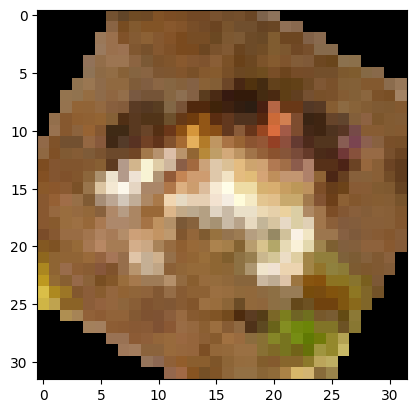

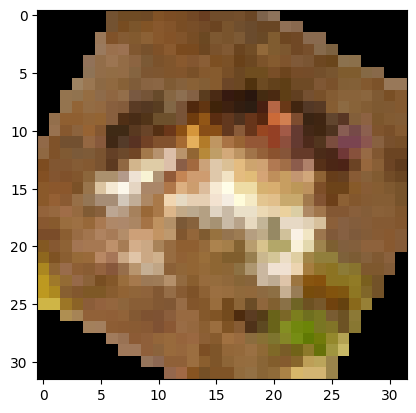

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt


transform = transforms.Compose([
    transforms.RandomRotation(30),                        
    transforms.ToTensor()
])

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
img, label = train_ds[0]
print(img.shape)

plt.imshow(img.permute(1,2,0))
plt.show()

img, label = train_ds[0]

plt.imshow(img.permute(1,2,0))
plt.show()

Widzimy tutaj kolejny potencjalny problem z augmentacjami: ze względu na konieczność utrzymania stałego kształtu wejścia, augmentacje mogą wprowadzać artefakty takie jak czarne fragmenty na krawędziach obrazu czy aliasing wynikający z niskiej rozdzielczości.

Poniżej kod pomocniczy z laboratorium 3, można zastąpić go własną implementacją pętli uczącej uwzględniającej ulepszenia wykonane na laboratoriach 4 i 5. W zadaniach poniżej wystarczy porównać końcowy wynik uczenia, nie jest wymagane wyrysowywanie pełnych krzywych w tensorboard niemniej mogą one pomóc w analizie otrzymanych wyników.

In [7]:
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from typing import Tuple
from tqdm import tqdm
from typing import List, Tuple
import itertools
from sklearn.metrics import f1_score

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

def count_correct(
    y_pred: torch.Tensor, y_true: torch.Tensor
) -> torch.Tensor:
    preds = torch.argmax(y_pred, dim=1)
    return (preds == y_true).float().sum()

def validate(
    model: nn.Module, 
    loss_fn: torch.nn.CrossEntropyLoss, 
    dataloader: DataLoader
) -> Tuple[torch.Tensor, torch.Tensor]:
    loss = 0
    correct = 0
    all = 0
    for X_batch, y_batch in dataloader:
        y_pred = model(X_batch.cuda())
        all += len(y_pred)
        loss += loss_fn(y_pred, y_batch.cuda()).sum()
        correct += count_correct(y_pred, y_batch.cuda())
    return loss / all, correct / all

def fit(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, 
    print_metrics: str = True
):

  train_losses_list = []
  train_acc_list = []
  test_losses_list = []
  test_acc_list = []


  for epoch in range(epochs):
      for X_batch, y_batch in tqdm(train_dl):
          y_pred = model(X_batch.cuda())
          loss = loss_fn(y_pred, y_batch.cuda())

          loss.backward()
          optimiser.step()
          optimiser.zero_grad()

      if print_metrics: 
          model.eval()
          with torch.no_grad():
              train_loss, train_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=train_dl
              ) 
              val_loss, val_acc = validate(
                  model=model, loss_fn=loss_fn, dataloader=val_dl
              )
              print(
                  f"Epoch {epoch}: "
                  f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                  f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
              )
          train_losses_list.append(float(train_loss))
          train_acc_list.append(float(train_acc))
          test_losses_list.append(float(val_loss))
          test_acc_list.append(float(val_acc))
  
  model.eval()

  y_true = []
  y_pred = []
  for X_test, y_test in val_dl:
    y_pred = model(X_test.cuda())
    f_score = f1_score(y_test.cpu().detach().numpy(), np.argmax(y_pred.cpu().detach().numpy(), axis=-1), average='micro')


  return val_acc, train_acc_list, test_acc_list, train_losses_list, test_losses_list, epochs, f_score 

Files already downloaded and verified
Files already downloaded and verified


# Zadanie 1

Wykorzystując klasę ThreeLayerCNN, spróbuj dobrać augmentacje danych tak aby poprawić wyniki względem jej braku na zbiorze CIFAR10.

In [3]:
class ThreeLayerCNN(torch.nn.Module):
  def __init__(self, channels: int, labels: int):
    super().__init__()
    self.model = torch.nn.Sequential()
    self.model.add_module("conv_1", 
                          torch.nn.Conv2d(3, channels, 3, padding=1))
    self.model.add_module("relu_1", torch.nn.ReLU())
    self.model.add_module("max_pool_1", torch.nn.MaxPool2d(2))
    self.model.add_module("conv_2", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("relu_2", torch.nn.ReLU())
    self.model.add_module("max_pool_2", torch.nn.MaxPool2d(2))
    self.model.add_module("conv3", 
                          torch.nn.Conv2d(channels, channels, 3, padding=1))
    self.model.add_module("flatten", torch.nn.Flatten())
    self.model.add_module("linear", torch.nn.Linear(8*8*channels, 10))
  
  def forward(self, x):
    return self.model(x)

Zaprogramuj eksperyment tak, aby w pętli sprawdzać kolejne potencjalne wersje potoku przetwarzania (różniące się tutaj tylko augmentacją), a na końcu wybrać najlepszą - tak aby możliwe było powtórzenie całego eksperymentu uzasadniającego wybór! Transformacja z augmentacją ma być wywoływana tylko na danych treningowych.

Spróbuj znaleźć również przykład augmentacji pogarszającej wynik w stosunku do bazowego otrzymanego bez augmentacji. Wykorzystaj uczenie na 50 epok i optymalizator Adam z domyślnymi parametrami, bez regularyzacji.

Trying transforms: ['RandomHorizontalFlip']
Files already downloaded and verified


100%|██████████| 1407/1407 [00:13<00:00, 106.90it/s]


Epoch 0: train loss = 0.039 (acc: 0.563), validation loss = 0.040 (acc: 0.546)


100%|██████████| 1407/1407 [00:12<00:00, 108.56it/s]


Epoch 1: train loss = 0.034 (acc: 0.620), validation loss = 0.035 (acc: 0.611)


100%|██████████| 1407/1407 [00:13<00:00, 105.72it/s]


Epoch 2: train loss = 0.030 (acc: 0.670), validation loss = 0.031 (acc: 0.658)


100%|██████████| 1407/1407 [00:12<00:00, 108.96it/s]


Epoch 3: train loss = 0.030 (acc: 0.660), validation loss = 0.032 (acc: 0.643)


100%|██████████| 1407/1407 [00:12<00:00, 109.61it/s]


Epoch 4: train loss = 0.029 (acc: 0.677), validation loss = 0.031 (acc: 0.658)


100%|██████████| 1407/1407 [00:13<00:00, 104.08it/s]


Epoch 5: train loss = 0.027 (acc: 0.700), validation loss = 0.029 (acc: 0.677)


100%|██████████| 1407/1407 [00:18<00:00, 74.65it/s]


Epoch 6: train loss = 0.026 (acc: 0.707), validation loss = 0.029 (acc: 0.693)


100%|██████████| 1407/1407 [00:12<00:00, 110.06it/s]


Epoch 7: train loss = 0.026 (acc: 0.712), validation loss = 0.028 (acc: 0.687)


100%|██████████| 1407/1407 [00:15<00:00, 88.38it/s]


Epoch 8: train loss = 0.026 (acc: 0.708), validation loss = 0.029 (acc: 0.684)


100%|██████████| 1407/1407 [00:12<00:00, 109.25it/s]


Epoch 9: train loss = 0.024 (acc: 0.728), validation loss = 0.028 (acc: 0.702)


100%|██████████| 1407/1407 [00:13<00:00, 107.12it/s]


Epoch 10: train loss = 0.024 (acc: 0.732), validation loss = 0.028 (acc: 0.697)


100%|██████████| 1407/1407 [00:12<00:00, 109.59it/s]


Epoch 11: train loss = 0.024 (acc: 0.729), validation loss = 0.029 (acc: 0.687)


100%|██████████| 1407/1407 [00:15<00:00, 91.16it/s] 


Epoch 12: train loss = 0.024 (acc: 0.732), validation loss = 0.028 (acc: 0.695)


100%|██████████| 1407/1407 [00:22<00:00, 62.10it/s]


Epoch 13: train loss = 0.023 (acc: 0.742), validation loss = 0.027 (acc: 0.702)


100%|██████████| 1407/1407 [00:16<00:00, 83.47it/s] 


Epoch 14: train loss = 0.023 (acc: 0.749), validation loss = 0.026 (acc: 0.713)


100%|██████████| 1407/1407 [00:16<00:00, 86.84it/s] 


Epoch 15: train loss = 0.023 (acc: 0.740), validation loss = 0.027 (acc: 0.707)


100%|██████████| 1407/1407 [00:14<00:00, 99.80it/s]


Epoch 16: train loss = 0.022 (acc: 0.753), validation loss = 0.027 (acc: 0.711)


100%|██████████| 1407/1407 [00:17<00:00, 80.60it/s]


Epoch 17: train loss = 0.022 (acc: 0.756), validation loss = 0.027 (acc: 0.720)


100%|██████████| 1407/1407 [00:14<00:00, 97.63it/s]


Epoch 18: train loss = 0.023 (acc: 0.744), validation loss = 0.027 (acc: 0.709)


100%|██████████| 1407/1407 [00:21<00:00, 66.34it/s]


Epoch 19: train loss = 0.023 (acc: 0.743), validation loss = 0.028 (acc: 0.701)


100%|██████████| 1407/1407 [00:13<00:00, 103.76it/s]


Epoch 20: train loss = 0.021 (acc: 0.762), validation loss = 0.027 (acc: 0.711)


100%|██████████| 1407/1407 [00:12<00:00, 108.96it/s]


Epoch 21: train loss = 0.021 (acc: 0.761), validation loss = 0.027 (acc: 0.713)


100%|██████████| 1407/1407 [00:12<00:00, 108.87it/s]


Epoch 22: train loss = 0.022 (acc: 0.760), validation loss = 0.027 (acc: 0.718)


100%|██████████| 1407/1407 [00:16<00:00, 86.70it/s] 


Epoch 23: train loss = 0.021 (acc: 0.767), validation loss = 0.026 (acc: 0.718)


100%|██████████| 1407/1407 [00:13<00:00, 105.06it/s]


Epoch 24: train loss = 0.021 (acc: 0.767), validation loss = 0.027 (acc: 0.713)


100%|██████████| 1407/1407 [00:15<00:00, 93.78it/s] 


Epoch 25: train loss = 0.022 (acc: 0.751), validation loss = 0.028 (acc: 0.700)


100%|██████████| 1407/1407 [00:13<00:00, 102.57it/s]


Epoch 26: train loss = 0.020 (acc: 0.776), validation loss = 0.026 (acc: 0.716)


100%|██████████| 1407/1407 [00:18<00:00, 78.14it/s] 


Epoch 27: train loss = 0.021 (acc: 0.766), validation loss = 0.027 (acc: 0.713)


100%|██████████| 1407/1407 [00:12<00:00, 109.67it/s]


Epoch 28: train loss = 0.020 (acc: 0.774), validation loss = 0.026 (acc: 0.716)


100%|██████████| 1407/1407 [00:18<00:00, 75.60it/s]


Epoch 29: train loss = 0.021 (acc: 0.765), validation loss = 0.028 (acc: 0.710)


100%|██████████| 1407/1407 [00:13<00:00, 106.43it/s]


Epoch 30: train loss = 0.021 (acc: 0.772), validation loss = 0.027 (acc: 0.715)


100%|██████████| 1407/1407 [00:13<00:00, 104.11it/s]


Epoch 31: train loss = 0.019 (acc: 0.783), validation loss = 0.025 (acc: 0.726)


100%|██████████| 1407/1407 [00:13<00:00, 107.54it/s]


Epoch 32: train loss = 0.020 (acc: 0.778), validation loss = 0.027 (acc: 0.725)


100%|██████████| 1407/1407 [00:13<00:00, 104.33it/s]


Epoch 33: train loss = 0.020 (acc: 0.780), validation loss = 0.026 (acc: 0.717)


100%|██████████| 1407/1407 [00:13<00:00, 107.50it/s]


Epoch 34: train loss = 0.019 (acc: 0.782), validation loss = 0.026 (acc: 0.728)
Validation accuracy: 0.728
Trying transforms: ['RandomCrop']
Files already downloaded and verified


100%|██████████| 1407/1407 [00:17<00:00, 78.55it/s]


Epoch 0: train loss = 0.030 (acc: 0.664), validation loss = 0.031 (acc: 0.661)


100%|██████████| 1407/1407 [00:24<00:00, 56.93it/s]


Epoch 1: train loss = 0.032 (acc: 0.638), validation loss = 0.033 (acc: 0.626)


100%|██████████| 1407/1407 [00:21<00:00, 65.17it/s]


Epoch 2: train loss = 0.030 (acc: 0.670), validation loss = 0.031 (acc: 0.662)


100%|██████████| 1407/1407 [00:15<00:00, 92.38it/s]


Epoch 3: train loss = 0.028 (acc: 0.677), validation loss = 0.030 (acc: 0.666)


100%|██████████| 1407/1407 [00:15<00:00, 89.05it/s]


Epoch 4: train loss = 0.029 (acc: 0.672), validation loss = 0.030 (acc: 0.660)


100%|██████████| 1407/1407 [00:15<00:00, 90.63it/s]


Epoch 5: train loss = 0.027 (acc: 0.699), validation loss = 0.028 (acc: 0.690)


100%|██████████| 1407/1407 [00:15<00:00, 89.10it/s]


Epoch 6: train loss = 0.028 (acc: 0.682), validation loss = 0.030 (acc: 0.670)


100%|██████████| 1407/1407 [00:15<00:00, 91.86it/s]


Epoch 7: train loss = 0.026 (acc: 0.703), validation loss = 0.029 (acc: 0.683)


100%|██████████| 1407/1407 [00:15<00:00, 88.94it/s]


Epoch 8: train loss = 0.026 (acc: 0.703), validation loss = 0.029 (acc: 0.689)


100%|██████████| 1407/1407 [00:15<00:00, 92.50it/s]


Epoch 9: train loss = 0.027 (acc: 0.702), validation loss = 0.028 (acc: 0.684)


100%|██████████| 1407/1407 [00:15<00:00, 91.85it/s]


Epoch 10: train loss = 0.026 (acc: 0.706), validation loss = 0.028 (acc: 0.690)


100%|██████████| 1407/1407 [00:15<00:00, 92.67it/s]


Epoch 11: train loss = 0.026 (acc: 0.708), validation loss = 0.028 (acc: 0.695)


100%|██████████| 1407/1407 [00:15<00:00, 92.15it/s]


Epoch 12: train loss = 0.026 (acc: 0.703), validation loss = 0.028 (acc: 0.691)


100%|██████████| 1407/1407 [00:15<00:00, 92.66it/s] 


Epoch 13: train loss = 0.026 (acc: 0.706), validation loss = 0.029 (acc: 0.696)


100%|██████████| 1407/1407 [00:15<00:00, 92.06it/s]


Epoch 14: train loss = 0.026 (acc: 0.707), validation loss = 0.028 (acc: 0.686)


100%|██████████| 1407/1407 [00:15<00:00, 88.33it/s]


Epoch 15: train loss = 0.027 (acc: 0.698), validation loss = 0.030 (acc: 0.678)


100%|██████████| 1407/1407 [00:15<00:00, 92.30it/s]


Epoch 16: train loss = 0.026 (acc: 0.704), validation loss = 0.028 (acc: 0.691)


100%|██████████| 1407/1407 [00:15<00:00, 88.10it/s]


Epoch 17: train loss = 0.026 (acc: 0.706), validation loss = 0.029 (acc: 0.695)


100%|██████████| 1407/1407 [00:15<00:00, 92.61it/s]


Epoch 18: train loss = 0.027 (acc: 0.697), validation loss = 0.029 (acc: 0.682)


100%|██████████| 1407/1407 [00:15<00:00, 90.71it/s]


Epoch 19: train loss = 0.025 (acc: 0.717), validation loss = 0.027 (acc: 0.696)


100%|██████████| 1407/1407 [00:15<00:00, 92.25it/s]


Epoch 20: train loss = 0.027 (acc: 0.703), validation loss = 0.029 (acc: 0.683)


100%|██████████| 1407/1407 [00:15<00:00, 93.25it/s]


Epoch 21: train loss = 0.027 (acc: 0.697), validation loss = 0.029 (acc: 0.684)


100%|██████████| 1407/1407 [00:15<00:00, 91.83it/s]


Epoch 22: train loss = 0.025 (acc: 0.718), validation loss = 0.028 (acc: 0.693)


100%|██████████| 1407/1407 [00:15<00:00, 91.47it/s]


Epoch 23: train loss = 0.026 (acc: 0.712), validation loss = 0.028 (acc: 0.685)


100%|██████████| 1407/1407 [00:15<00:00, 89.31it/s]


Epoch 24: train loss = 0.026 (acc: 0.703), validation loss = 0.029 (acc: 0.685)


100%|██████████| 1407/1407 [00:15<00:00, 92.49it/s]


Epoch 25: train loss = 0.025 (acc: 0.722), validation loss = 0.028 (acc: 0.705)


100%|██████████| 1407/1407 [00:15<00:00, 91.71it/s]


Epoch 26: train loss = 0.025 (acc: 0.722), validation loss = 0.028 (acc: 0.693)


100%|██████████| 1407/1407 [00:15<00:00, 93.20it/s]


Epoch 27: train loss = 0.025 (acc: 0.721), validation loss = 0.028 (acc: 0.694)


100%|██████████| 1407/1407 [00:18<00:00, 75.82it/s]


Epoch 28: train loss = 0.025 (acc: 0.717), validation loss = 0.027 (acc: 0.702)


100%|██████████| 1407/1407 [00:15<00:00, 88.55it/s]


Epoch 29: train loss = 0.024 (acc: 0.731), validation loss = 0.027 (acc: 0.708)


100%|██████████| 1407/1407 [00:15<00:00, 88.45it/s]


Epoch 30: train loss = 0.026 (acc: 0.710), validation loss = 0.029 (acc: 0.687)


100%|██████████| 1407/1407 [00:15<00:00, 92.38it/s]


Epoch 31: train loss = 0.025 (acc: 0.718), validation loss = 0.028 (acc: 0.689)


100%|██████████| 1407/1407 [00:15<00:00, 89.82it/s]


Epoch 32: train loss = 0.025 (acc: 0.720), validation loss = 0.027 (acc: 0.703)


100%|██████████| 1407/1407 [00:15<00:00, 92.21it/s] 


Epoch 33: train loss = 0.026 (acc: 0.713), validation loss = 0.028 (acc: 0.689)


100%|██████████| 1407/1407 [00:15<00:00, 92.98it/s]


Epoch 34: train loss = 0.024 (acc: 0.727), validation loss = 0.027 (acc: 0.708)
Validation accuracy: 0.708
Trying transforms: ['RandomRotation']
Files already downloaded and verified


100%|██████████| 1407/1407 [00:14<00:00, 94.01it/s]


Epoch 0: train loss = 0.026 (acc: 0.709), validation loss = 0.027 (acc: 0.697)


100%|██████████| 1407/1407 [00:14<00:00, 93.92it/s]


Epoch 1: train loss = 0.025 (acc: 0.718), validation loss = 0.027 (acc: 0.711)


100%|██████████| 1407/1407 [00:15<00:00, 90.42it/s]


Epoch 2: train loss = 0.025 (acc: 0.719), validation loss = 0.027 (acc: 0.703)


100%|██████████| 1407/1407 [00:15<00:00, 93.52it/s]


Epoch 3: train loss = 0.025 (acc: 0.715), validation loss = 0.027 (acc: 0.696)


100%|██████████| 1407/1407 [00:15<00:00, 92.51it/s]


Epoch 4: train loss = 0.025 (acc: 0.723), validation loss = 0.026 (acc: 0.711)


100%|██████████| 1407/1407 [00:14<00:00, 94.60it/s]


Epoch 5: train loss = 0.024 (acc: 0.727), validation loss = 0.027 (acc: 0.711)


100%|██████████| 1407/1407 [00:15<00:00, 93.20it/s]


Epoch 6: train loss = 0.024 (acc: 0.728), validation loss = 0.027 (acc: 0.713)


100%|██████████| 1407/1407 [00:15<00:00, 90.47it/s]


Epoch 7: train loss = 0.024 (acc: 0.732), validation loss = 0.026 (acc: 0.708)


100%|██████████| 1407/1407 [00:15<00:00, 92.88it/s]


Epoch 8: train loss = 0.024 (acc: 0.725), validation loss = 0.027 (acc: 0.707)


100%|██████████| 1407/1407 [00:15<00:00, 90.54it/s]


Epoch 9: train loss = 0.026 (acc: 0.706), validation loss = 0.028 (acc: 0.687)


100%|██████████| 1407/1407 [00:15<00:00, 90.77it/s]


Epoch 10: train loss = 0.024 (acc: 0.730), validation loss = 0.027 (acc: 0.700)


100%|██████████| 1407/1407 [00:15<00:00, 89.29it/s]


Epoch 11: train loss = 0.024 (acc: 0.735), validation loss = 0.026 (acc: 0.718)


100%|██████████| 1407/1407 [00:15<00:00, 93.15it/s]


Epoch 12: train loss = 0.024 (acc: 0.724), validation loss = 0.027 (acc: 0.706)


100%|██████████| 1407/1407 [00:15<00:00, 93.54it/s]


Epoch 13: train loss = 0.024 (acc: 0.734), validation loss = 0.027 (acc: 0.713)


100%|██████████| 1407/1407 [00:15<00:00, 91.01it/s]


Epoch 14: train loss = 0.024 (acc: 0.732), validation loss = 0.026 (acc: 0.709)


100%|██████████| 1407/1407 [00:15<00:00, 92.86it/s]


Epoch 15: train loss = 0.024 (acc: 0.725), validation loss = 0.028 (acc: 0.695)


100%|██████████| 1407/1407 [00:15<00:00, 89.78it/s]


Epoch 16: train loss = 0.024 (acc: 0.733), validation loss = 0.027 (acc: 0.709)


100%|██████████| 1407/1407 [00:15<00:00, 93.52it/s]


Epoch 17: train loss = 0.024 (acc: 0.722), validation loss = 0.027 (acc: 0.708)


100%|██████████| 1407/1407 [00:14<00:00, 94.41it/s] 


Epoch 18: train loss = 0.024 (acc: 0.727), validation loss = 0.027 (acc: 0.697)


100%|██████████| 1407/1407 [00:15<00:00, 93.10it/s]


Epoch 19: train loss = 0.024 (acc: 0.731), validation loss = 0.027 (acc: 0.702)


100%|██████████| 1407/1407 [00:15<00:00, 93.76it/s] 


Epoch 20: train loss = 0.025 (acc: 0.721), validation loss = 0.028 (acc: 0.693)


100%|██████████| 1407/1407 [00:15<00:00, 90.03it/s] 


Epoch 21: train loss = 0.024 (acc: 0.735), validation loss = 0.027 (acc: 0.708)


100%|██████████| 1407/1407 [00:15<00:00, 93.04it/s]


Epoch 22: train loss = 0.024 (acc: 0.735), validation loss = 0.026 (acc: 0.713)


100%|██████████| 1407/1407 [00:15<00:00, 91.32it/s]


Epoch 23: train loss = 0.024 (acc: 0.731), validation loss = 0.027 (acc: 0.702)


100%|██████████| 1407/1407 [00:15<00:00, 92.68it/s]


Epoch 24: train loss = 0.024 (acc: 0.732), validation loss = 0.027 (acc: 0.704)


100%|██████████| 1407/1407 [00:14<00:00, 94.32it/s]


Epoch 25: train loss = 0.024 (acc: 0.735), validation loss = 0.027 (acc: 0.708)


100%|██████████| 1407/1407 [00:15<00:00, 91.62it/s]


Epoch 26: train loss = 0.023 (acc: 0.739), validation loss = 0.027 (acc: 0.708)


100%|██████████| 1407/1407 [00:14<00:00, 95.12it/s]


Epoch 27: train loss = 0.024 (acc: 0.730), validation loss = 0.027 (acc: 0.706)


100%|██████████| 1407/1407 [00:15<00:00, 90.39it/s]


Epoch 28: train loss = 0.025 (acc: 0.721), validation loss = 0.028 (acc: 0.700)


100%|██████████| 1407/1407 [00:14<00:00, 94.19it/s]


Epoch 29: train loss = 0.024 (acc: 0.730), validation loss = 0.027 (acc: 0.694)


100%|██████████| 1407/1407 [00:14<00:00, 94.05it/s]


Epoch 30: train loss = 0.023 (acc: 0.738), validation loss = 0.027 (acc: 0.704)


100%|██████████| 1407/1407 [00:15<00:00, 91.34it/s]


Epoch 31: train loss = 0.023 (acc: 0.742), validation loss = 0.027 (acc: 0.702)


100%|██████████| 1407/1407 [00:15<00:00, 93.57it/s]


Epoch 32: train loss = 0.023 (acc: 0.743), validation loss = 0.026 (acc: 0.705)


100%|██████████| 1407/1407 [00:15<00:00, 89.84it/s]


Epoch 33: train loss = 0.024 (acc: 0.730), validation loss = 0.028 (acc: 0.697)


100%|██████████| 1407/1407 [00:15<00:00, 93.16it/s]


Epoch 34: train loss = 0.023 (acc: 0.743), validation loss = 0.027 (acc: 0.707)
Validation accuracy: 0.707
Trying transforms: ['ColorJitter']
Files already downloaded and verified


100%|██████████| 1407/1407 [00:37<00:00, 37.95it/s]


Epoch 0: train loss = 0.022 (acc: 0.759), validation loss = 0.024 (acc: 0.743)


100%|██████████| 1407/1407 [00:37<00:00, 38.00it/s]


Epoch 1: train loss = 0.021 (acc: 0.765), validation loss = 0.023 (acc: 0.740)


100%|██████████| 1407/1407 [00:37<00:00, 37.61it/s]


Epoch 2: train loss = 0.021 (acc: 0.770), validation loss = 0.025 (acc: 0.733)


100%|██████████| 1407/1407 [00:37<00:00, 37.75it/s]


Epoch 3: train loss = 0.021 (acc: 0.771), validation loss = 0.025 (acc: 0.730)


100%|██████████| 1407/1407 [00:37<00:00, 38.01it/s]


Epoch 4: train loss = 0.020 (acc: 0.780), validation loss = 0.024 (acc: 0.734)


100%|██████████| 1407/1407 [00:37<00:00, 37.88it/s]


Epoch 5: train loss = 0.019 (acc: 0.784), validation loss = 0.025 (acc: 0.732)


100%|██████████| 1407/1407 [00:37<00:00, 37.64it/s]


Epoch 6: train loss = 0.020 (acc: 0.775), validation loss = 0.026 (acc: 0.710)


100%|██████████| 1407/1407 [00:37<00:00, 37.79it/s]


Epoch 7: train loss = 0.020 (acc: 0.777), validation loss = 0.025 (acc: 0.727)


100%|██████████| 1407/1407 [00:37<00:00, 37.64it/s]


Epoch 8: train loss = 0.019 (acc: 0.788), validation loss = 0.026 (acc: 0.724)


100%|██████████| 1407/1407 [00:37<00:00, 37.70it/s]


Epoch 9: train loss = 0.020 (acc: 0.773), validation loss = 0.027 (acc: 0.714)


100%|██████████| 1407/1407 [00:37<00:00, 37.74it/s]


Epoch 10: train loss = 0.018 (acc: 0.792), validation loss = 0.026 (acc: 0.722)


100%|██████████| 1407/1407 [00:37<00:00, 37.89it/s]


Epoch 11: train loss = 0.019 (acc: 0.792), validation loss = 0.026 (acc: 0.723)


100%|██████████| 1407/1407 [00:37<00:00, 37.74it/s]


Epoch 12: train loss = 0.019 (acc: 0.788), validation loss = 0.027 (acc: 0.728)


100%|██████████| 1407/1407 [00:37<00:00, 37.76it/s]


Epoch 13: train loss = 0.019 (acc: 0.791), validation loss = 0.027 (acc: 0.722)


100%|██████████| 1407/1407 [00:37<00:00, 37.94it/s]


Epoch 14: train loss = 0.018 (acc: 0.801), validation loss = 0.026 (acc: 0.727)


100%|██████████| 1407/1407 [00:37<00:00, 37.93it/s]


Epoch 15: train loss = 0.018 (acc: 0.799), validation loss = 0.027 (acc: 0.719)


100%|██████████| 1407/1407 [00:36<00:00, 38.15it/s]


Epoch 16: train loss = 0.018 (acc: 0.801), validation loss = 0.026 (acc: 0.716)


100%|██████████| 1407/1407 [00:37<00:00, 37.93it/s]


Epoch 17: train loss = 0.018 (acc: 0.801), validation loss = 0.027 (acc: 0.722)


100%|██████████| 1407/1407 [00:37<00:00, 37.91it/s]


Epoch 18: train loss = 0.017 (acc: 0.808), validation loss = 0.027 (acc: 0.721)


100%|██████████| 1407/1407 [00:37<00:00, 37.77it/s]


Epoch 19: train loss = 0.018 (acc: 0.794), validation loss = 0.027 (acc: 0.717)


100%|██████████| 1407/1407 [00:37<00:00, 37.99it/s]


Epoch 20: train loss = 0.019 (acc: 0.789), validation loss = 0.029 (acc: 0.710)


100%|██████████| 1407/1407 [00:37<00:00, 37.60it/s]


Epoch 21: train loss = 0.018 (acc: 0.794), validation loss = 0.029 (acc: 0.705)


100%|██████████| 1407/1407 [00:37<00:00, 37.51it/s]


Epoch 22: train loss = 0.017 (acc: 0.806), validation loss = 0.028 (acc: 0.715)


100%|██████████| 1407/1407 [00:37<00:00, 37.77it/s]


Epoch 23: train loss = 0.017 (acc: 0.812), validation loss = 0.027 (acc: 0.719)


100%|██████████| 1407/1407 [00:37<00:00, 37.80it/s]


Epoch 24: train loss = 0.017 (acc: 0.809), validation loss = 0.028 (acc: 0.713)


100%|██████████| 1407/1407 [00:36<00:00, 38.05it/s]


Epoch 25: train loss = 0.017 (acc: 0.816), validation loss = 0.027 (acc: 0.718)


100%|██████████| 1407/1407 [00:36<00:00, 38.07it/s]


Epoch 26: train loss = 0.017 (acc: 0.804), validation loss = 0.028 (acc: 0.711)


100%|██████████| 1407/1407 [00:37<00:00, 37.84it/s]


Epoch 27: train loss = 0.017 (acc: 0.801), validation loss = 0.028 (acc: 0.708)


100%|██████████| 1407/1407 [00:36<00:00, 38.09it/s]


Epoch 28: train loss = 0.018 (acc: 0.799), validation loss = 0.030 (acc: 0.706)


100%|██████████| 1407/1407 [00:37<00:00, 37.75it/s]


Epoch 29: train loss = 0.017 (acc: 0.810), validation loss = 0.029 (acc: 0.712)


100%|██████████| 1407/1407 [00:37<00:00, 37.80it/s]


Epoch 30: train loss = 0.016 (acc: 0.819), validation loss = 0.028 (acc: 0.718)


100%|██████████| 1407/1407 [00:37<00:00, 37.41it/s]


Epoch 31: train loss = 0.017 (acc: 0.808), validation loss = 0.030 (acc: 0.709)


100%|██████████| 1407/1407 [00:37<00:00, 37.09it/s]


Epoch 32: train loss = 0.017 (acc: 0.806), validation loss = 0.029 (acc: 0.712)


100%|██████████| 1407/1407 [00:37<00:00, 37.20it/s]


Epoch 33: train loss = 0.017 (acc: 0.806), validation loss = 0.030 (acc: 0.706)


100%|██████████| 1407/1407 [00:37<00:00, 37.53it/s]


Epoch 34: train loss = 0.018 (acc: 0.797), validation loss = 0.029 (acc: 0.694)
Validation accuracy: 0.694
Best set of transforms: ['RandomHorizontalFlip']
Best validation accuracy: 0.728


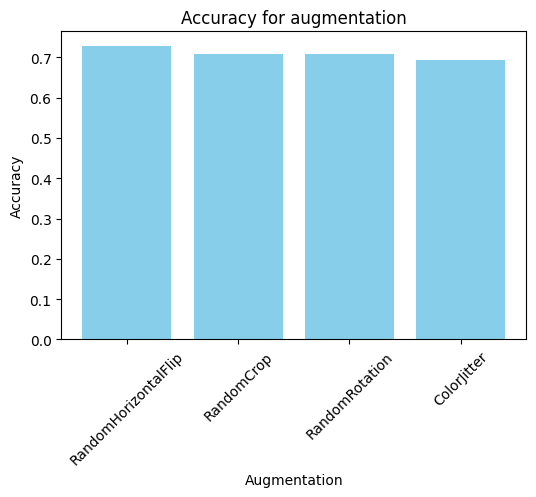

In [5]:
accuracy_list = []
model = ThreeLayerCNN(channels=32, labels=10).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

transforms_list = [
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomCrop(size=32, padding=4),
    torchvision.transforms.RandomRotation(degrees=20),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
]

best_transforms = None
best_val_acc = 0


for transforms in itertools.combinations(transforms_list, 1):
    print(f"Trying transforms: {[type(t).__name__ for t in transforms]}")
    transform = torchvision.transforms.Compose(list(transforms) + [torchvision.transforms.ToTensor()])
    train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
    train_ds, val_ds = torch.utils.data.random_split(train_ds, [0.9,0.1])
    train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size=32, pin_memory=True)
    val_acc = fit(model=model, optimiser=optimizer, loss_fn=loss_fn,
                  train_dl=train_dl, val_dl=val_dl, epochs=35)
    accuracy_list.append(val_acc.cpu())

    print(f"Validation accuracy: {val_acc:.3f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_transforms = transforms

print(f"Best set of transforms: {[type(t).__name__ for t in best_transforms]}")
print(f"Best validation accuracy: {best_val_acc:.3f}")

labels = ["RandomHorizontalFlip", "RandomCrop", "RandomRotation", "ColorJitter"]

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracy_list, color='skyblue')
plt.title('Accuracy for augmentation')
plt.xlabel('Augmentation')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.show()



In [10]:
import numpy as np 
transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

_, train_acc_list1, test_acc_list1, train_losses_list1, test_losses_list1, epochs, f1_1 = fit(model=model, optimiser=optimizer, 
                                                                  loss_fn=loss_fn, train_dl=train_dl, val_dl=test_dl, epochs=35)


transform = torchvision.transforms.Compose(list(best_transforms) + [torchvision.transforms.ToTensor()])
train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)

_ , train_acc_list2, test_acc_list2, train_losses_list2, test_losses_list2, epochs, f1_2 = fit(model=model, optimiser=optimizer, 
                                                                  loss_fn=loss_fn, train_dl=train_dl, val_dl=test_dl, epochs=35)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:11<00:00, 137.40it/s]


Epoch 0: train loss = 0.012 (acc: 0.857), validation loss = 0.033 (acc: 0.706)


100%|██████████| 1563/1563 [00:11<00:00, 137.55it/s]


Epoch 1: train loss = 0.011 (acc: 0.871), validation loss = 0.035 (acc: 0.704)


100%|██████████| 1563/1563 [00:11<00:00, 136.79it/s]


Epoch 2: train loss = 0.010 (acc: 0.884), validation loss = 0.035 (acc: 0.705)


100%|██████████| 1563/1563 [00:11<00:00, 138.37it/s]


Epoch 3: train loss = 0.010 (acc: 0.879), validation loss = 0.036 (acc: 0.705)


100%|██████████| 1563/1563 [00:11<00:00, 137.91it/s]


Epoch 4: train loss = 0.010 (acc: 0.883), validation loss = 0.036 (acc: 0.705)


100%|██████████| 1563/1563 [00:11<00:00, 136.80it/s]


Epoch 5: train loss = 0.010 (acc: 0.881), validation loss = 0.036 (acc: 0.703)


100%|██████████| 1563/1563 [00:11<00:00, 135.43it/s]


Epoch 6: train loss = 0.010 (acc: 0.885), validation loss = 0.036 (acc: 0.706)


100%|██████████| 1563/1563 [00:11<00:00, 135.67it/s]


Epoch 7: train loss = 0.011 (acc: 0.871), validation loss = 0.038 (acc: 0.700)


100%|██████████| 1563/1563 [00:11<00:00, 136.00it/s]


Epoch 8: train loss = 0.012 (acc: 0.863), validation loss = 0.038 (acc: 0.693)


100%|██████████| 1563/1563 [00:11<00:00, 138.43it/s]


Epoch 9: train loss = 0.011 (acc: 0.876), validation loss = 0.037 (acc: 0.700)


100%|██████████| 1563/1563 [00:11<00:00, 134.14it/s]


Epoch 10: train loss = 0.011 (acc: 0.876), validation loss = 0.038 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 136.42it/s]


Epoch 11: train loss = 0.012 (acc: 0.865), validation loss = 0.039 (acc: 0.695)


100%|██████████| 1563/1563 [00:11<00:00, 137.44it/s]


Epoch 12: train loss = 0.010 (acc: 0.880), validation loss = 0.037 (acc: 0.700)


100%|██████████| 1563/1563 [00:11<00:00, 134.23it/s]


Epoch 13: train loss = 0.010 (acc: 0.883), validation loss = 0.039 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 136.98it/s]


Epoch 14: train loss = 0.011 (acc: 0.869), validation loss = 0.040 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 137.37it/s]


Epoch 15: train loss = 0.011 (acc: 0.874), validation loss = 0.040 (acc: 0.697)


100%|██████████| 1563/1563 [00:11<00:00, 137.48it/s]


Epoch 16: train loss = 0.010 (acc: 0.886), validation loss = 0.039 (acc: 0.699)


100%|██████████| 1563/1563 [00:11<00:00, 135.19it/s]


Epoch 17: train loss = 0.009 (acc: 0.891), validation loss = 0.039 (acc: 0.702)


100%|██████████| 1563/1563 [00:11<00:00, 134.91it/s]


Epoch 18: train loss = 0.011 (acc: 0.868), validation loss = 0.041 (acc: 0.694)


100%|██████████| 1563/1563 [00:11<00:00, 137.35it/s]


Epoch 19: train loss = 0.010 (acc: 0.883), validation loss = 0.040 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 140.14it/s]


Epoch 20: train loss = 0.010 (acc: 0.880), validation loss = 0.040 (acc: 0.697)


100%|██████████| 1563/1563 [00:11<00:00, 134.60it/s]


Epoch 21: train loss = 0.010 (acc: 0.878), validation loss = 0.042 (acc: 0.692)


100%|██████████| 1563/1563 [00:11<00:00, 136.55it/s]


Epoch 22: train loss = 0.010 (acc: 0.883), validation loss = 0.040 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 137.11it/s]


Epoch 23: train loss = 0.011 (acc: 0.876), validation loss = 0.041 (acc: 0.691)


100%|██████████| 1563/1563 [00:11<00:00, 135.63it/s]


Epoch 24: train loss = 0.010 (acc: 0.882), validation loss = 0.041 (acc: 0.694)


100%|██████████| 1563/1563 [00:11<00:00, 134.04it/s]


Epoch 25: train loss = 0.010 (acc: 0.886), validation loss = 0.040 (acc: 0.695)


100%|██████████| 1563/1563 [00:11<00:00, 137.08it/s]


Epoch 26: train loss = 0.009 (acc: 0.893), validation loss = 0.041 (acc: 0.697)


100%|██████████| 1563/1563 [00:11<00:00, 136.37it/s]


Epoch 27: train loss = 0.010 (acc: 0.889), validation loss = 0.040 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 134.58it/s]


Epoch 28: train loss = 0.009 (acc: 0.897), validation loss = 0.041 (acc: 0.697)


100%|██████████| 1563/1563 [00:11<00:00, 133.97it/s]


Epoch 29: train loss = 0.010 (acc: 0.883), validation loss = 0.041 (acc: 0.690)


100%|██████████| 1563/1563 [00:11<00:00, 135.45it/s]


Epoch 30: train loss = 0.010 (acc: 0.888), validation loss = 0.040 (acc: 0.694)


100%|██████████| 1563/1563 [00:11<00:00, 137.42it/s]


Epoch 31: train loss = 0.009 (acc: 0.889), validation loss = 0.041 (acc: 0.698)


100%|██████████| 1563/1563 [00:11<00:00, 134.17it/s]


Epoch 32: train loss = 0.010 (acc: 0.888), validation loss = 0.041 (acc: 0.695)


100%|██████████| 1563/1563 [00:11<00:00, 135.20it/s]


Epoch 33: train loss = 0.010 (acc: 0.884), validation loss = 0.042 (acc: 0.696)


100%|██████████| 1563/1563 [00:11<00:00, 135.78it/s]


Epoch 34: train loss = 0.010 (acc: 0.888), validation loss = 0.043 (acc: 0.694)
Files already downloaded and verified


100%|██████████| 1563/1563 [00:14<00:00, 110.64it/s]


Epoch 0: train loss = 0.021 (acc: 0.782), validation loss = 0.031 (acc: 0.710)


100%|██████████| 1563/1563 [00:14<00:00, 106.73it/s]


Epoch 1: train loss = 0.020 (acc: 0.787), validation loss = 0.028 (acc: 0.720)


100%|██████████| 1563/1563 [00:14<00:00, 111.01it/s]


Epoch 2: train loss = 0.019 (acc: 0.797), validation loss = 0.028 (acc: 0.724)


100%|██████████| 1563/1563 [00:14<00:00, 110.18it/s]


Epoch 3: train loss = 0.019 (acc: 0.796), validation loss = 0.027 (acc: 0.724)


100%|██████████| 1563/1563 [00:14<00:00, 110.15it/s]


Epoch 4: train loss = 0.019 (acc: 0.794), validation loss = 0.027 (acc: 0.722)


100%|██████████| 1563/1563 [00:14<00:00, 106.92it/s]


Epoch 5: train loss = 0.019 (acc: 0.793), validation loss = 0.027 (acc: 0.720)


100%|██████████| 1563/1563 [00:14<00:00, 110.86it/s]


Epoch 6: train loss = 0.018 (acc: 0.797), validation loss = 0.027 (acc: 0.721)


100%|██████████| 1563/1563 [00:13<00:00, 111.64it/s]


Epoch 7: train loss = 0.017 (acc: 0.806), validation loss = 0.026 (acc: 0.733)


100%|██████████| 1563/1563 [00:14<00:00, 111.00it/s]


Epoch 8: train loss = 0.017 (acc: 0.810), validation loss = 0.026 (acc: 0.735)


100%|██████████| 1563/1563 [00:14<00:00, 106.15it/s]


Epoch 9: train loss = 0.018 (acc: 0.802), validation loss = 0.027 (acc: 0.730)


100%|██████████| 1563/1563 [00:13<00:00, 111.88it/s]


Epoch 10: train loss = 0.017 (acc: 0.810), validation loss = 0.026 (acc: 0.731)


100%|██████████| 1563/1563 [00:14<00:00, 110.43it/s]


Epoch 11: train loss = 0.018 (acc: 0.799), validation loss = 0.027 (acc: 0.723)


100%|██████████| 1563/1563 [00:14<00:00, 109.77it/s]


Epoch 12: train loss = 0.017 (acc: 0.806), validation loss = 0.026 (acc: 0.728)


100%|██████████| 1563/1563 [00:14<00:00, 107.60it/s]


Epoch 13: train loss = 0.017 (acc: 0.812), validation loss = 0.026 (acc: 0.732)


100%|██████████| 1563/1563 [00:14<00:00, 110.38it/s]


Epoch 14: train loss = 0.017 (acc: 0.806), validation loss = 0.026 (acc: 0.727)


100%|██████████| 1563/1563 [00:14<00:00, 110.49it/s]


Epoch 15: train loss = 0.017 (acc: 0.812), validation loss = 0.026 (acc: 0.731)


100%|██████████| 1563/1563 [00:13<00:00, 111.67it/s]


Epoch 16: train loss = 0.017 (acc: 0.812), validation loss = 0.026 (acc: 0.739)


100%|██████████| 1563/1563 [00:14<00:00, 108.61it/s]


Epoch 17: train loss = 0.018 (acc: 0.793), validation loss = 0.026 (acc: 0.722)


100%|██████████| 1563/1563 [00:14<00:00, 111.08it/s]


Epoch 18: train loss = 0.017 (acc: 0.811), validation loss = 0.026 (acc: 0.738)


100%|██████████| 1563/1563 [00:14<00:00, 111.09it/s]


Epoch 19: train loss = 0.018 (acc: 0.795), validation loss = 0.028 (acc: 0.715)


100%|██████████| 1563/1563 [00:13<00:00, 112.11it/s]


Epoch 20: train loss = 0.016 (acc: 0.818), validation loss = 0.025 (acc: 0.737)


100%|██████████| 1563/1563 [00:14<00:00, 107.81it/s]


Epoch 21: train loss = 0.018 (acc: 0.804), validation loss = 0.027 (acc: 0.728)


100%|██████████| 1563/1563 [00:14<00:00, 111.47it/s]


Epoch 22: train loss = 0.017 (acc: 0.810), validation loss = 0.026 (acc: 0.734)


100%|██████████| 1563/1563 [00:14<00:00, 109.79it/s]


Epoch 23: train loss = 0.017 (acc: 0.815), validation loss = 0.026 (acc: 0.729)


100%|██████████| 1563/1563 [00:14<00:00, 110.53it/s]


Epoch 24: train loss = 0.018 (acc: 0.804), validation loss = 0.027 (acc: 0.722)


100%|██████████| 1563/1563 [00:14<00:00, 108.07it/s]


Epoch 25: train loss = 0.016 (acc: 0.815), validation loss = 0.026 (acc: 0.734)


100%|██████████| 1563/1563 [00:13<00:00, 112.29it/s]


Epoch 26: train loss = 0.017 (acc: 0.811), validation loss = 0.026 (acc: 0.733)


100%|██████████| 1563/1563 [00:14<00:00, 110.74it/s]


Epoch 27: train loss = 0.016 (acc: 0.822), validation loss = 0.026 (acc: 0.740)


100%|██████████| 1563/1563 [00:14<00:00, 111.22it/s]


Epoch 28: train loss = 0.018 (acc: 0.795), validation loss = 0.027 (acc: 0.716)


100%|██████████| 1563/1563 [00:14<00:00, 108.39it/s]


Epoch 29: train loss = 0.017 (acc: 0.804), validation loss = 0.027 (acc: 0.724)


100%|██████████| 1563/1563 [00:14<00:00, 111.16it/s]


Epoch 30: train loss = 0.017 (acc: 0.812), validation loss = 0.026 (acc: 0.729)


100%|██████████| 1563/1563 [00:14<00:00, 110.52it/s]


Epoch 31: train loss = 0.016 (acc: 0.821), validation loss = 0.026 (acc: 0.736)


100%|██████████| 1563/1563 [00:14<00:00, 109.86it/s]


Epoch 32: train loss = 0.017 (acc: 0.811), validation loss = 0.027 (acc: 0.734)


100%|██████████| 1563/1563 [00:14<00:00, 107.16it/s]


Epoch 33: train loss = 0.017 (acc: 0.813), validation loss = 0.026 (acc: 0.732)


100%|██████████| 1563/1563 [00:13<00:00, 111.70it/s]


Epoch 34: train loss = 0.017 (acc: 0.810), validation loss = 0.026 (acc: 0.729)


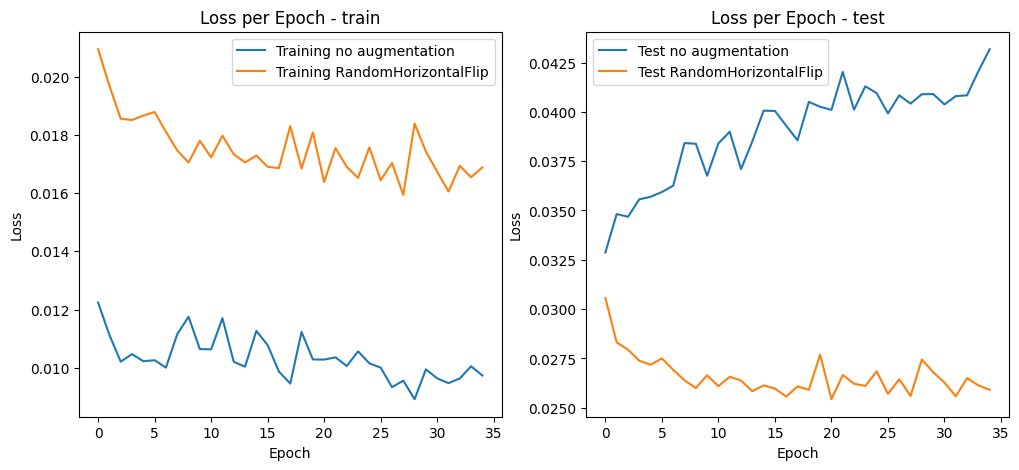

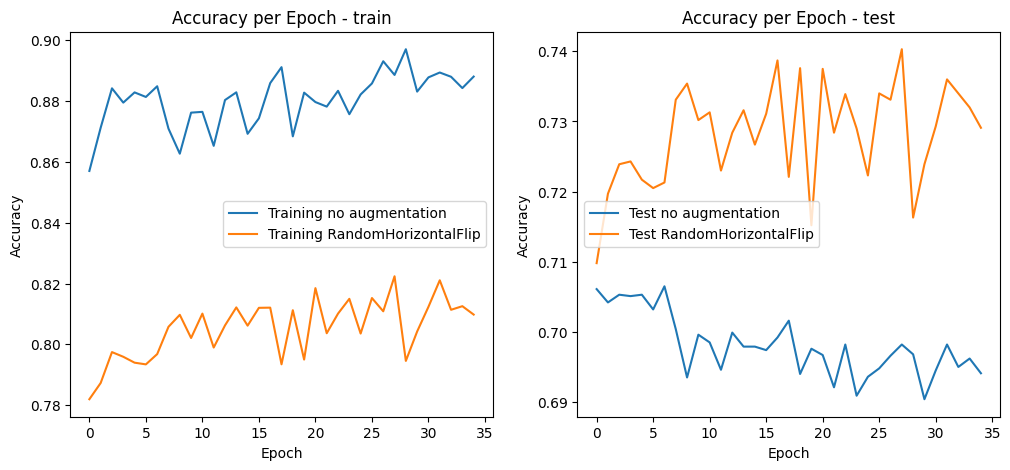

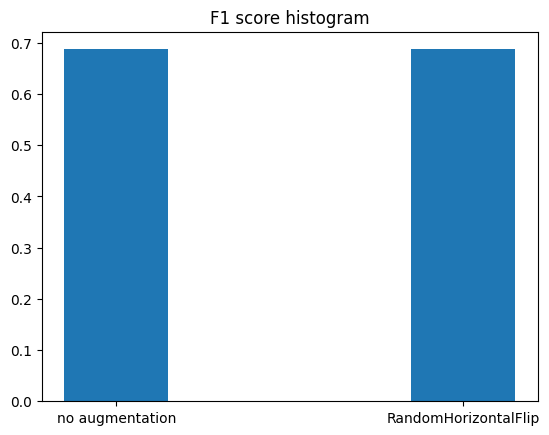

In [11]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs),train_losses_list1, label="Training no augmentation")
ax[0].plot(range(epochs),train_losses_list2, label="Training RandomHorizontalFlip")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss per Epoch - train")
ax[0].legend()

ax[1].plot(range(epochs),test_losses_list1, label="Test no augmentation")
ax[1].plot(range(epochs),test_losses_list2, label="Test RandomHorizontalFlip")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss per Epoch - test")
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs),train_acc_list1, label="Training no augmentation")
ax[0].plot(range(epochs),train_acc_list2, label="Training RandomHorizontalFlip")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy per Epoch - train")
ax[0].legend()

ax[1].plot(range(epochs),test_acc_list1, label="Test no augmentation")
ax[1].plot(range(epochs),test_acc_list2, label="Test RandomHorizontalFlip")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy per Epoch - test")
ax[1].legend()
plt.show()

f_list = [f1_1, f1_2]
x=[1,2]

plt.bar(x, f_list, width=0.3)
plt.title('F1 score histogram')
plt.xticks([1, 2], ['no augmentation', 'RandomHorizontalFlip'])

plt.show()

# Mixup - augmentacja ogólna

Augmentacja daje nam spore możliwości w sytuacji, gdy w dziedzinie danych jesteśmy w stanie wskazać przekształcenia na kóre nasz model powinien być **inwariantny** - dla obrazków niewielkie skalowanie czy przesunięcie nie powinno zmieniać wyniku, zaś dla tekstu, podstawianie synonimów może spełniać podobną rolę. Ale w augmentacji danych możliwe jest też podejście niezależne od typu danych, wynikające z obserwacji dotyczących dynamiki uczenia sieci głębokich w ogóle. Ciekawym przykładem jest tu augmentacja Mixup:

https://arxiv.org/abs/1710.09412

Zasada działania mixup jest niezwykle prosta - generujemy nowe przykłady jako **kombinacje liniowe** tych istniejących w zbiorze danych i oczekujemy, że ich etykiety również będą kombinacjami liniowymi etykiet. Innymi słowy, dla pary przykładów z etykietami: $(x_1, y_1)$, $(x_2, y_2)$, możemy wygenerować przykład $(x', y')$:

$x' = \lambda x_1 + (1-\lambda) x_2$

$y' = \lambda y_1 + (1-\lambda) y_2$

Wartość $\lambda$ jest tutaj losowana z rozkładu Beta - animacja podana na https://en.wikipedia.org/wiki/Beta_distribution#Definitions dobrze obrazuje, jak wygląda ten rozkład dla różnych parametryzacji.

# Zadanie 2

Zmodyfikuj funkcję fit tak, aby uczyć zgodnie z podanym wyżej sformułowaniem augmentacji Mixup. Uwaga: będzie to wymagało modyfikacji funkcji kosztu!

In [12]:
import numpy as np


def fit_mixup(
    model: nn.Module, optimiser: optim.Optimizer, 
    loss_fn: torch.nn.CrossEntropyLoss, train_dl: DataLoader, 
    val_dl: DataLoader, epochs: int, alpha: float = 1.0,
    print_metrics: str = True
):

    train_losses_list = []
    train_acc_list = []
    test_losses_list = []
    test_acc_list = []

    for epoch in range(epochs):
        for X_batch, y_batch in tqdm(train_dl):

            # Generate mixup examples
            lam = np.random.beta(alpha, alpha)
            index = torch.randperm(X_batch.size()[0])
            mixed_X = lam * X_batch + (1 - lam) * X_batch[index, :]
            y_a, y_b = y_batch, y_batch[index]
            mixed_y = lam * y_a + (1 - lam) * y_b
            mixed_y = mixed_y.long()
            # Forward pass and loss calculation
            logits = model(mixed_X.cuda())
            loss = lam * loss_fn(logits, y_a.cuda()) + (1 - lam) * loss_fn(logits, y_b.cuda())

            # Backward pass and optimization
            loss.backward()
            optimiser.step()
            optimiser.zero_grad()

        if print_metrics: 
            model.eval()
            with torch.no_grad():
                train_loss, train_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=train_dl
                ) 
                val_loss, val_acc = validate(
                    model=model, loss_fn=loss_fn, dataloader=val_dl
                )
                print(
                    f"Epoch {epoch}: "
                    f"train loss = {train_loss:.3f} (acc: {train_acc:.3f}), "
                    f"validation loss = {val_loss:.3f} (acc: {val_acc:.3f})"
                )
            train_losses_list.append(float(train_loss))
            train_acc_list.append(float(train_acc))
            test_losses_list.append(float(val_loss))
            test_acc_list.append(float(val_acc))
  
    model.eval()

    y_true = []
    y_pred = []
    for X_test, y_test in val_dl:
      y_pred = model(X_test.cuda())
      f_score = f1_score(y_test.cpu().detach().numpy(), np.argmax(y_pred.cpu().detach().numpy(), axis=-1), average='micro')

    return train_acc_list, test_acc_list, train_losses_list, test_losses_list, epochs, f_score 
    

Sprawdź, czy uzyskuje ona przewagę nad modelem trenowanym bez augmentacji. 



In [15]:
model = ThreeLayerCNN(channels=32, labels=10).cuda()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

train_acc_list3, test_acc_list3, train_losses_list3, test_losses_list3, epochs, f1_3 = fit_mixup(model=model, optimiser=optimizer, 
                                                                  loss_fn=loss_fn, train_dl=train_dl, val_dl=test_dl, epochs=35)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:12<00:00, 124.03it/s]


Epoch 0: train loss = 0.042 (acc: 0.535), validation loss = 0.042 (acc: 0.526)


100%|██████████| 1563/1563 [00:12<00:00, 125.62it/s]


Epoch 1: train loss = 0.037 (acc: 0.595), validation loss = 0.038 (acc: 0.586)


100%|██████████| 1563/1563 [00:12<00:00, 124.95it/s]


Epoch 2: train loss = 0.034 (acc: 0.636), validation loss = 0.036 (acc: 0.619)


100%|██████████| 1563/1563 [00:12<00:00, 124.27it/s]


Epoch 3: train loss = 0.032 (acc: 0.652), validation loss = 0.034 (acc: 0.633)


100%|██████████| 1563/1563 [00:12<00:00, 125.21it/s]


Epoch 4: train loss = 0.034 (acc: 0.635), validation loss = 0.036 (acc: 0.615)


100%|██████████| 1563/1563 [00:12<00:00, 126.56it/s]


Epoch 5: train loss = 0.031 (acc: 0.680), validation loss = 0.033 (acc: 0.652)


100%|██████████| 1563/1563 [00:12<00:00, 124.78it/s]


Epoch 6: train loss = 0.030 (acc: 0.685), validation loss = 0.033 (acc: 0.656)


100%|██████████| 1563/1563 [00:12<00:00, 125.06it/s]


Epoch 7: train loss = 0.029 (acc: 0.699), validation loss = 0.031 (acc: 0.670)


100%|██████████| 1563/1563 [00:12<00:00, 125.81it/s]


Epoch 8: train loss = 0.030 (acc: 0.696), validation loss = 0.032 (acc: 0.660)


100%|██████████| 1563/1563 [00:12<00:00, 126.68it/s]


Epoch 9: train loss = 0.028 (acc: 0.704), validation loss = 0.031 (acc: 0.670)


100%|██████████| 1563/1563 [00:12<00:00, 126.00it/s]


Epoch 10: train loss = 0.028 (acc: 0.721), validation loss = 0.031 (acc: 0.678)


100%|██████████| 1563/1563 [00:12<00:00, 126.00it/s]


Epoch 11: train loss = 0.027 (acc: 0.725), validation loss = 0.030 (acc: 0.678)


100%|██████████| 1563/1563 [00:12<00:00, 125.92it/s]


Epoch 12: train loss = 0.028 (acc: 0.715), validation loss = 0.031 (acc: 0.671)


100%|██████████| 1563/1563 [00:12<00:00, 125.95it/s]


Epoch 13: train loss = 0.027 (acc: 0.718), validation loss = 0.031 (acc: 0.670)


100%|██████████| 1563/1563 [00:12<00:00, 124.77it/s]


Epoch 14: train loss = 0.028 (acc: 0.716), validation loss = 0.031 (acc: 0.674)


100%|██████████| 1563/1563 [00:12<00:00, 126.60it/s]


Epoch 15: train loss = 0.026 (acc: 0.734), validation loss = 0.030 (acc: 0.690)


100%|██████████| 1563/1563 [00:12<00:00, 126.20it/s]


Epoch 16: train loss = 0.026 (acc: 0.742), validation loss = 0.030 (acc: 0.692)


100%|██████████| 1563/1563 [00:12<00:00, 124.65it/s]


Epoch 17: train loss = 0.026 (acc: 0.741), validation loss = 0.029 (acc: 0.693)


100%|██████████| 1563/1563 [00:12<00:00, 124.64it/s]


Epoch 18: train loss = 0.026 (acc: 0.737), validation loss = 0.030 (acc: 0.685)


100%|██████████| 1563/1563 [00:12<00:00, 124.93it/s]


Epoch 19: train loss = 0.026 (acc: 0.736), validation loss = 0.030 (acc: 0.680)


100%|██████████| 1563/1563 [00:12<00:00, 126.00it/s]


Epoch 20: train loss = 0.025 (acc: 0.755), validation loss = 0.029 (acc: 0.699)


100%|██████████| 1563/1563 [00:12<00:00, 122.29it/s]


Epoch 21: train loss = 0.026 (acc: 0.740), validation loss = 0.030 (acc: 0.688)


100%|██████████| 1563/1563 [00:12<00:00, 123.11it/s]


Epoch 22: train loss = 0.026 (acc: 0.732), validation loss = 0.030 (acc: 0.677)


100%|██████████| 1563/1563 [00:12<00:00, 124.73it/s]


Epoch 23: train loss = 0.026 (acc: 0.735), validation loss = 0.031 (acc: 0.673)


100%|██████████| 1563/1563 [00:12<00:00, 125.82it/s]


Epoch 24: train loss = 0.025 (acc: 0.741), validation loss = 0.030 (acc: 0.677)


100%|██████████| 1563/1563 [00:12<00:00, 124.72it/s]


Epoch 25: train loss = 0.025 (acc: 0.753), validation loss = 0.029 (acc: 0.694)


100%|██████████| 1563/1563 [00:12<00:00, 124.96it/s]


Epoch 26: train loss = 0.026 (acc: 0.737), validation loss = 0.031 (acc: 0.677)


100%|██████████| 1563/1563 [00:12<00:00, 124.21it/s]


Epoch 27: train loss = 0.025 (acc: 0.758), validation loss = 0.030 (acc: 0.694)


100%|██████████| 1563/1563 [00:12<00:00, 125.11it/s]


Epoch 28: train loss = 0.025 (acc: 0.750), validation loss = 0.029 (acc: 0.684)


100%|██████████| 1563/1563 [00:12<00:00, 126.18it/s]


Epoch 29: train loss = 0.024 (acc: 0.759), validation loss = 0.029 (acc: 0.697)


100%|██████████| 1563/1563 [00:12<00:00, 123.69it/s]


Epoch 30: train loss = 0.024 (acc: 0.757), validation loss = 0.029 (acc: 0.689)


100%|██████████| 1563/1563 [00:12<00:00, 125.45it/s]


Epoch 31: train loss = 0.025 (acc: 0.755), validation loss = 0.030 (acc: 0.687)


100%|██████████| 1563/1563 [00:12<00:00, 125.33it/s]


Epoch 32: train loss = 0.024 (acc: 0.758), validation loss = 0.029 (acc: 0.691)


100%|██████████| 1563/1563 [00:12<00:00, 126.45it/s]


Epoch 33: train loss = 0.024 (acc: 0.760), validation loss = 0.029 (acc: 0.691)


100%|██████████| 1563/1563 [00:12<00:00, 125.23it/s]


Epoch 34: train loss = 0.024 (acc: 0.756), validation loss = 0.030 (acc: 0.683)


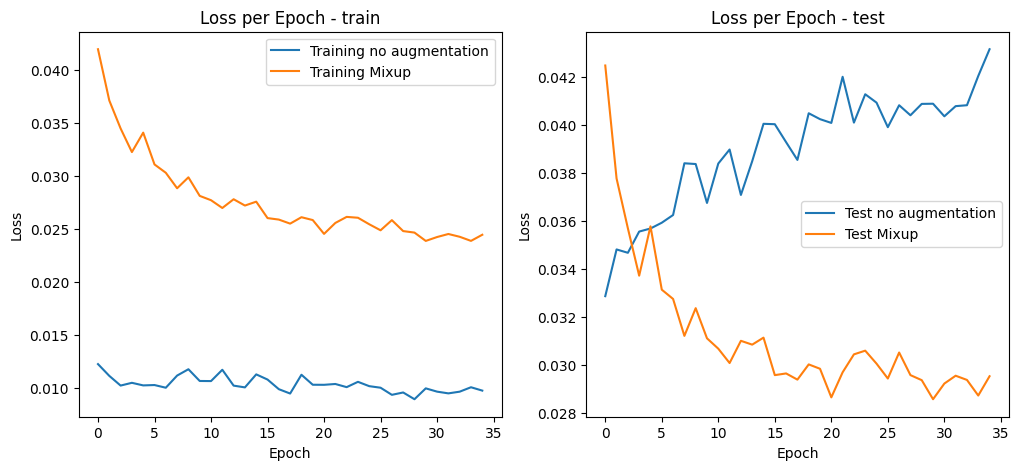

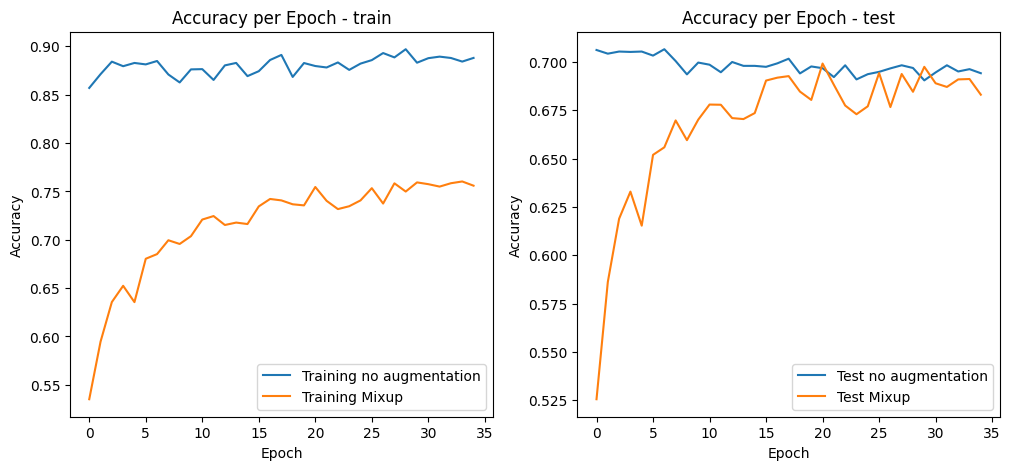

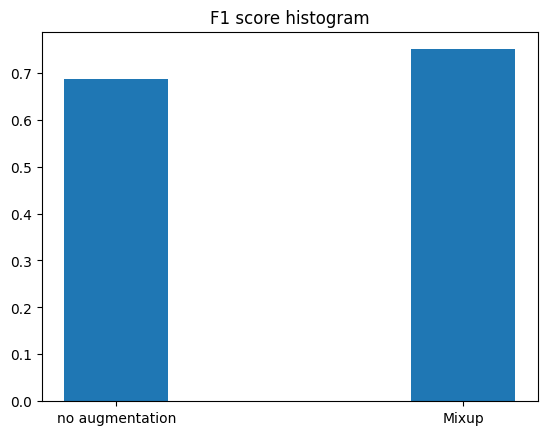

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs),train_losses_list1, label="Training no augmentation")
ax[0].plot(range(epochs),train_losses_list3, label="Training Mixup")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss per Epoch - train")
ax[0].legend()

ax[1].plot(range(epochs),test_losses_list1, label="Test no augmentation")
ax[1].plot(range(epochs),test_losses_list3, label="Test Mixup")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss per Epoch - test")
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs),train_acc_list1, label="Training no augmentation")
ax[0].plot(range(epochs),train_acc_list3, label="Training Mixup")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy per Epoch - train")
ax[0].legend()

ax[1].plot(range(epochs),test_acc_list1, label="Test no augmentation")
ax[1].plot(range(epochs),test_acc_list3, label="Test Mixup")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy per Epoch - test")
ax[1].legend()
plt.show()

f_list = [f1_1, f1_3]
x=[1,2]

plt.bar(x, f_list, width=0.3)
plt.title('F1 score histogram')
plt.xticks([1, 2], ['no augmentation', 'Mixup'])

plt.show()

# Skrótowe połączenia

W kontekście sieci konwolucyjnych warto zpoznać się jeszcze z jedną istotną koncepcją: połączenia omijające warstwy, poprzez konkatenacje ich wyniku z wynikami dalszych warstw lub dodawanie ich wyniku do wyjścia dalszej warstwy (w drugim przypadku mówimy też o połączeniach *rezydualnych*). Połączenia takie są potrzebne szczególnie przy trenowaniu sieci bardzo głębokich, zawierających dziesiątki czy nawet ponad 100 warstw, czego nie będziemy w stanie realistycznie zrealizować w czasie naszych laboratoriów. Niemniej warto zapoznać się zarówno z samą ideą, jak i ich implementacją, jako że przy pracy z architekturami *state of the art* będziemy często natykać się na takie konstrukcje.

W konstrukcji sieci z połączeniamy pomijającymi warstwy i połączeniami rezydualnymi często będziemy spotykać się z powtarzalnymi *blokami* obejmującymi kilka warstw - dobrą praktyką implementacyjną jest wydzielanie takich bloków jako osobnych podklas `torch.nn.Module`. Warto też z góry zwrócić uwagę, że znane nam już `torch.nn.Sequential` nie uwzględnia połączeń innych niż sekwencyjne - czyli połączenia rezydualne i omijanie warstw nie wchodzi w grę, chyba że w obrębie wydzielonego bloku.

# Zadanie 3

Uzupełnij kod klasy SkipBlock tak, aby implementowała blok o zadanej strukturze.

Struktura SkipBlock:

główna sekwencja warstw

*   warstwa konwolucyjna, nie zmieniająca wymiarów szerokość/wysokość, `in_channels x out_channels`, filtr 3x3
*   aktywacja ReLU
*   warstwa konwolucyjna, wykonująca downsampling x2 w wymiarach szerokość/wysokość, filtr 3x3

warstwa poboczna (na wejściu: wejście do całego bloku, wyjście dodawane jest do wyjścia sekwencji powyżej)

*    warstwa konwolucyjna, filtr 2x2

**Samodzielnie dobierz niesprecyzowane parametry** tak, aby wymiary odpowiednich wyjść się zgadzały. Wyjście bloku powinno mieć `out_channels` kanałów oraz dwukrotnie zmniejszoną wysokość i szerokość w stosunku do wejścia.

In [17]:
class SkipBlock(torch.nn.Module):
    def __init__(self, in_channels: int, out_channels: int):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = torch.nn.ReLU()
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1)
        self.side_conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size=2, stride=2)

    def forward(self, x):
        out = self.conv1(x)
        out = self.relu(out)
        out = self.conv2(out)
        side_out = self.side_conv(x)
        out += side_out
        out = self.relu(out)
        return out

class SkipBlockCNN(torch.nn.Module):
    def __init__(self, channels: List[int], labels: int):
        super().__init__()
        self.model = torch.nn.Sequential()
        self.model.add_module("res_1", SkipBlock(3, channels[0]))
        self.model.add_module("relu_1", torch.nn.ReLU())
        self.model.add_module("res_2", SkipBlock(channels[0], channels[1]))
        self.model.add_module("relu_2", torch.nn.ReLU())
        self.model.add_module("res_3", SkipBlock(channels[1], channels[2]))
        self.model.add_module("relu_3", torch.nn.ReLU())
        self.model.add_module("flatten", torch.nn.Flatten())
        self.model.add_module("linear", torch.nn.Linear(4*4*channels[2], labels))

    def forward(self, x):
        return self.model(x)

 Wyucz sieć SkipBlockCNN i porównaj jej wyniki z wcześniej uzykanymi.

In [18]:
model = SkipBlockCNN([16,32,64], labels=10).cuda()

optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

transform = torchvision.transforms.ToTensor()

train_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, download=True)
test_ds = torchvision.datasets.CIFAR10("cifar_root", transform=transform, train=False, download=True)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True, pin_memory=True)
test_dl = DataLoader(test_ds, batch_size=32, pin_memory=True)

_ , train_acc_list4, test_acc_list4, train_losses_list4, test_losses_list4, epochs, f1_4 = fit(model=model, optimiser=optimizer, 
                                                                  loss_fn=loss_fn, train_dl=train_dl, val_dl=test_dl, epochs=35)

Files already downloaded and verified
Files already downloaded and verified


100%|██████████| 1563/1563 [00:13<00:00, 114.56it/s]


Epoch 0: train loss = 0.040 (acc: 0.538), validation loss = 0.041 (acc: 0.523)


100%|██████████| 1563/1563 [00:13<00:00, 116.85it/s]


Epoch 1: train loss = 0.032 (acc: 0.638), validation loss = 0.035 (acc: 0.610)


100%|██████████| 1563/1563 [00:13<00:00, 118.35it/s]


Epoch 2: train loss = 0.030 (acc: 0.660), validation loss = 0.034 (acc: 0.616)


100%|██████████| 1563/1563 [00:13<00:00, 115.72it/s]


Epoch 3: train loss = 0.026 (acc: 0.709), validation loss = 0.031 (acc: 0.651)


100%|██████████| 1563/1563 [00:13<00:00, 116.21it/s]


Epoch 4: train loss = 0.022 (acc: 0.764), validation loss = 0.029 (acc: 0.680)


100%|██████████| 1563/1563 [00:13<00:00, 116.61it/s]


Epoch 5: train loss = 0.019 (acc: 0.788), validation loss = 0.028 (acc: 0.689)


100%|██████████| 1563/1563 [00:13<00:00, 116.14it/s]


Epoch 6: train loss = 0.018 (acc: 0.806), validation loss = 0.029 (acc: 0.690)


100%|██████████| 1563/1563 [00:13<00:00, 116.63it/s]


Epoch 7: train loss = 0.016 (acc: 0.824), validation loss = 0.029 (acc: 0.688)


100%|██████████| 1563/1563 [00:13<00:00, 116.45it/s]


Epoch 8: train loss = 0.015 (acc: 0.840), validation loss = 0.031 (acc: 0.688)


100%|██████████| 1563/1563 [00:13<00:00, 117.51it/s]


Epoch 9: train loss = 0.014 (acc: 0.846), validation loss = 0.032 (acc: 0.679)


100%|██████████| 1563/1563 [00:13<00:00, 116.75it/s]


Epoch 10: train loss = 0.012 (acc: 0.866), validation loss = 0.032 (acc: 0.683)


100%|██████████| 1563/1563 [00:13<00:00, 115.53it/s]


Epoch 11: train loss = 0.011 (acc: 0.878), validation loss = 0.034 (acc: 0.675)


100%|██████████| 1563/1563 [00:13<00:00, 113.48it/s]


Epoch 12: train loss = 0.010 (acc: 0.893), validation loss = 0.036 (acc: 0.675)


100%|██████████| 1563/1563 [00:14<00:00, 110.23it/s]


Epoch 13: train loss = 0.008 (acc: 0.913), validation loss = 0.038 (acc: 0.680)


100%|██████████| 1563/1563 [00:13<00:00, 113.89it/s]


Epoch 14: train loss = 0.009 (acc: 0.901), validation loss = 0.042 (acc: 0.670)


100%|██████████| 1563/1563 [00:13<00:00, 112.55it/s]


Epoch 15: train loss = 0.007 (acc: 0.916), validation loss = 0.044 (acc: 0.672)


100%|██████████| 1563/1563 [00:13<00:00, 115.99it/s]


Epoch 16: train loss = 0.007 (acc: 0.923), validation loss = 0.046 (acc: 0.665)


100%|██████████| 1563/1563 [00:13<00:00, 116.15it/s]


Epoch 17: train loss = 0.006 (acc: 0.926), validation loss = 0.048 (acc: 0.671)


100%|██████████| 1563/1563 [00:13<00:00, 117.34it/s]


Epoch 18: train loss = 0.005 (acc: 0.941), validation loss = 0.051 (acc: 0.671)


100%|██████████| 1563/1563 [00:13<00:00, 115.11it/s]


Epoch 19: train loss = 0.006 (acc: 0.933), validation loss = 0.054 (acc: 0.661)


100%|██████████| 1563/1563 [00:13<00:00, 114.14it/s]


Epoch 20: train loss = 0.005 (acc: 0.944), validation loss = 0.054 (acc: 0.666)


100%|██████████| 1563/1563 [00:13<00:00, 114.74it/s]


Epoch 21: train loss = 0.005 (acc: 0.945), validation loss = 0.058 (acc: 0.659)


100%|██████████| 1563/1563 [00:13<00:00, 113.71it/s]


Epoch 22: train loss = 0.005 (acc: 0.941), validation loss = 0.061 (acc: 0.660)


100%|██████████| 1563/1563 [00:13<00:00, 116.26it/s]


Epoch 23: train loss = 0.004 (acc: 0.949), validation loss = 0.064 (acc: 0.659)


100%|██████████| 1563/1563 [00:13<00:00, 113.31it/s]


Epoch 24: train loss = 0.004 (acc: 0.951), validation loss = 0.066 (acc: 0.661)


100%|██████████| 1563/1563 [00:13<00:00, 113.44it/s]


Epoch 25: train loss = 0.004 (acc: 0.950), validation loss = 0.065 (acc: 0.658)


100%|██████████| 1563/1563 [00:13<00:00, 115.69it/s]


Epoch 26: train loss = 0.004 (acc: 0.949), validation loss = 0.068 (acc: 0.661)


100%|██████████| 1563/1563 [00:13<00:00, 116.01it/s]


Epoch 27: train loss = 0.005 (acc: 0.947), validation loss = 0.069 (acc: 0.657)


100%|██████████| 1563/1563 [00:13<00:00, 114.49it/s]


Epoch 28: train loss = 0.004 (acc: 0.951), validation loss = 0.072 (acc: 0.660)


100%|██████████| 1563/1563 [00:14<00:00, 110.10it/s]


Epoch 29: train loss = 0.004 (acc: 0.953), validation loss = 0.073 (acc: 0.661)


100%|██████████| 1563/1563 [00:13<00:00, 113.15it/s]


Epoch 30: train loss = 0.003 (acc: 0.965), validation loss = 0.073 (acc: 0.664)


100%|██████████| 1563/1563 [00:13<00:00, 114.13it/s]


Epoch 31: train loss = 0.004 (acc: 0.960), validation loss = 0.075 (acc: 0.665)


100%|██████████| 1563/1563 [00:13<00:00, 114.71it/s]


Epoch 32: train loss = 0.004 (acc: 0.954), validation loss = 0.074 (acc: 0.657)


100%|██████████| 1563/1563 [00:13<00:00, 115.19it/s]


Epoch 33: train loss = 0.004 (acc: 0.955), validation loss = 0.078 (acc: 0.652)


100%|██████████| 1563/1563 [00:13<00:00, 114.34it/s]


Epoch 34: train loss = 0.003 (acc: 0.961), validation loss = 0.079 (acc: 0.661)


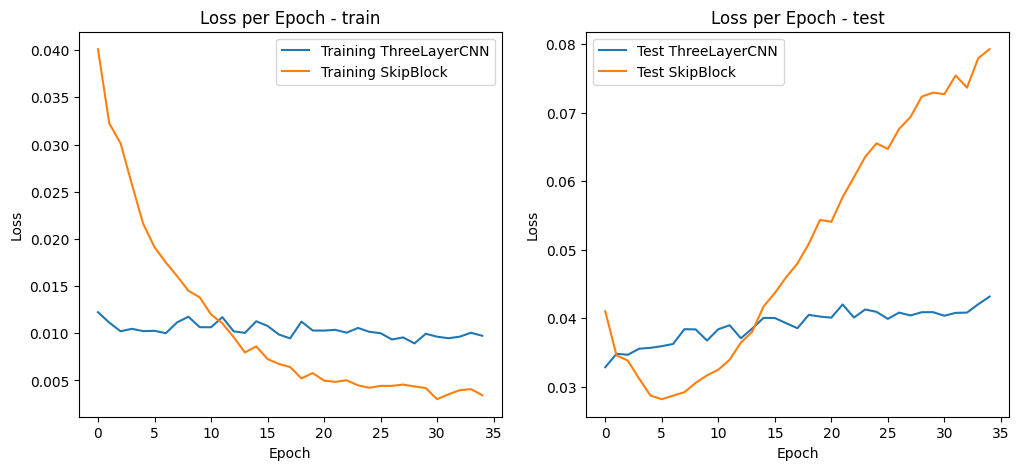

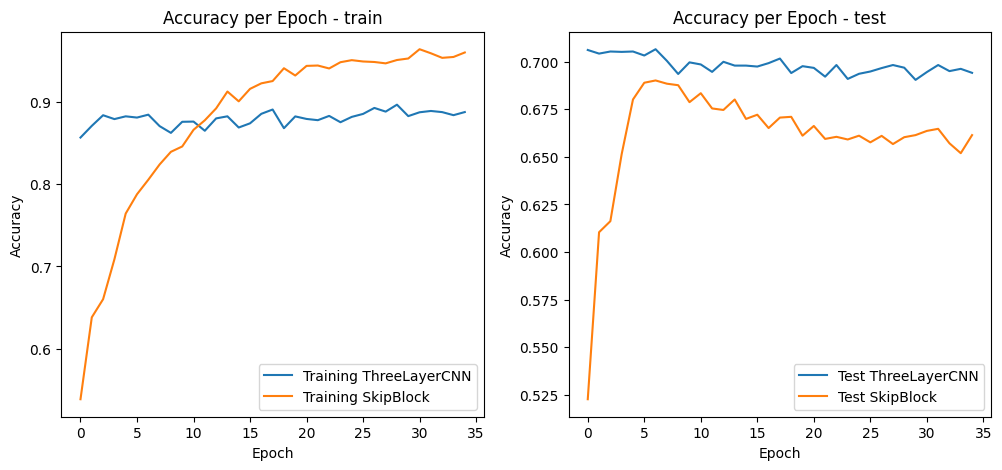

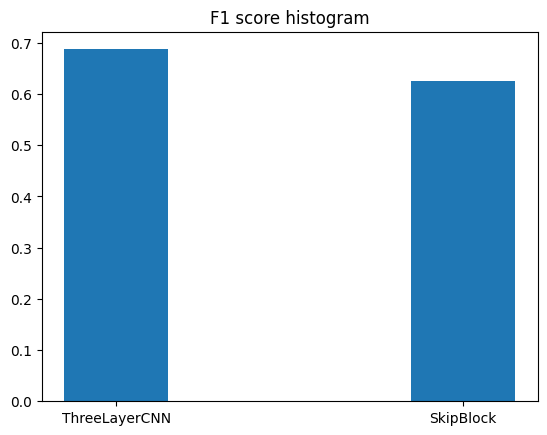

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].plot(range(epochs),train_losses_list1, label="Training ThreeLayerCNN")
ax[0].plot(range(epochs),train_losses_list4, label="Training SkipBlock")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].set_title("Loss per Epoch - train")
ax[0].legend()

ax[1].plot(range(epochs),test_losses_list1, label="Test ThreeLayerCNN")
ax[1].plot(range(epochs),test_losses_list4, label="Test SkipBlock")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss per Epoch - test")
ax[1].legend()

plt.show()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(range(epochs),train_acc_list1, label="Training ThreeLayerCNN")
ax[0].plot(range(epochs),train_acc_list4, label="Training SkipBlock")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy per Epoch - train")
ax[0].legend()

ax[1].plot(range(epochs),test_acc_list1, label="Test ThreeLayerCNN")
ax[1].plot(range(epochs),test_acc_list4, label="Test SkipBlock")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].set_title("Accuracy per Epoch - test")
ax[1].legend()
plt.show()

f_list = [f1_1, f1_4]
x=[1,2]

plt.bar(x, f_list, width=0.3)
plt.title('F1 score histogram')
plt.xticks([1, 2], ['ThreeLayerCNN', 'SkipBlock'])

plt.show()